# Denver Traffic Woes
## University of Denver Data Analytics Bootcamp
### Team BMALTT
### April 13, 2019
#### Presenters:
* Angela Stowell
* Lucy Ly
* Bri Von Feldt
* Tatsuya Sakurai
* Tai Johnson
* Matthew Stewart

---

## Purpose
The purpose of this project was to analyze trends in both traffic incidents and population growth from the years 2012 through 2018.  In particular, we wanted to answer the following questions:
1. What is the categorical breakdown of traffic incidents over the years 2012-2018?
2. In what locations are traffic incidents most highly concentrated?  Do the presence of traffic cameras correlate with reduced numbers of incidents?
2. Has the occurrence of traffic incidents worsened as population has grown?

---

## Data Sources
* Denver Traffic Accidents:  [https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents)
* Colorado Population Projections:  [https://data.colorado.gov/Demographics/Population-Projections-in-Colorado/q5vp-adf3](https://data.colorado.gov/Demographics/Population-Projections-in-Colorado/q5vp-adf3)
* Denver Traffic Camera Locations:  [https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-intelligent-traffic-system-devices](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-intelligent-traffic-system-devices)

## Conclusions
Through the analysis and visualization of the data in our data sources, as shown below, our conclusions are as follows:
1. The categorical breakdown of traffic incidents over the years has remained consistent, with the top two categories being (1) Routine Accident and (2) Hit and Run.
2. Traffic incidents appear to be most highly concentrated along I-25, I-70 and in the heart of downtown Denver.  Higher concentration of traffic cameras appear to correlate with a reduced number of incidents.
3. The total number of accidents has steadily increased over the years as population has increased.  However, an interesting observation is that, when calculating the number of accidents **per 1000 people**, this number has slightly decreased since 2015.

## Initial Setup

In [1]:
# Dependencies

import pandas as pd
import matplotlib.pyplot as plt
import gmaps
import requests
import json
import numpy as np
import warnings
from ipywidgets.embed import embed_minimal_html

# API Key for Google Maps API requests
from config import gkey 

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Initial dataframe for traffic accidents
init_traffic_data = pd.read_csv("../Resources/traffic_accidents.csv")
init_traffic_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURENCE_DATE,LAST_OCCURENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
0,200,2.012513e+09,201251274154010,5401,0,TRAF-HIT & RUN,TRAF - ACCIDENT - HIT & RUN,2012-11-02 18:20:00,None,2012-11-03 08:52:00,1900 BLOCK S SHERIDAN BLVD,3125852.0,1673648.0,-105.052849,39.682112,4,421,Harvey Park,0,0
1,201,2.012516e+09,201251634354410,5441,0,TRF-ACCIDENT,TRAF - ACCIDENT,2012-11-05 14:16:00,None,2012-11-05 15:12:00,E HAMPDEN AVE / S YOSEMITE ST,3173225.0,1663345.0,-104.884786,39.653067,3,323,Hampden South,0,0
2,203,2.012141e+09,201214081754010,5401,0,TRAF-HIT & RUN,TRAF - ACCIDENT - HIT & RUN,2012-04-02 17:00:00,None,2012-04-06 14:37:00,1300 BLOCK N BROADWAY ST,3144304.0,1693793.0,-104.986886,39.737147,6,623,Capitol Hill,0,0
3,204,2.012253e+09,201225335454410,5441,0,TRF-ACCIDENT,TRAF - ACCIDENT,2012-06-11 17:05:00,None,2012-06-11 17:43:00,600 BLOCK E EXPOSITION AVE,3146357.0,1681693.0,-104.979833,39.703898,3,311,Washington Park West,0,0
4,206,2.012119e+09,201211878854410,5441,0,TRF-ACCIDENT,TRAF - ACCIDENT,2012-03-23 11:01:00,None,2012-03-23 11:10:00.000001,I25 HWYSB / W COLFAX AVE,3136627.0,1694950.0,-105.014162,39.740439,1,121,Lincoln Park,0,0


In [4]:
#dropping unneeded columns
traffic_data = init_traffic_data.drop(labels=["GEO_X","GEO_Y","OBJECTID_1","INCIDENT_ID","OFFENSE_ID",
                                              "LAST_OCCURENCE_DATE","REPORTED_DATE","OFFENSE_TYPE_ID",
                                              "OFFENSE_CATEGORY_ID"],axis=1)

In [5]:
#renaming columns a *little* better
traffic_data.rename(columns={"FIRST_OCCURENCE_DATE":"ACCIDENT_DATE","GEO_LON":"LON","GEO_LAT":"LAT"},inplace=True)

In [6]:
#splitting date&time stamp to usable columns
date_split = traffic_data["ACCIDENT_DATE"].str.split(" ",expand=True,n=1)
traffic_data["DATE"] = date_split[0]
traffic_data["TIME"] = date_split[1]

date_split = traffic_data["DATE"].str.split("-",expand=True,n=2)
traffic_data["YEAR"] = date_split[0]
traffic_data["MONTH"] = date_split[1]
traffic_data["DAY"] = date_split[2]

#dropping superfluous columns that resulted from the above date/time splitting
traffic_data.drop(labels=["ACCIDENT_DATE","DATE"],axis=1,inplace=True)
traffic_data['OVERALL_OFFENSE_CODE'] = traffic_data['OFFENSE_CODE'].map(str) + traffic_data['OFFENSE_CODE_EXTENSION'].map(str)

#dropping 2019 data as it's not a full year
traffic_data = traffic_data[traffic_data['YEAR'] != "2019"]

In [7]:
#adding cleaned up offense descriptions, since they're way more useful than a code

descriptionlist = []
for eachcode in traffic_data['OVERALL_OFFENSE_CODE']:
    if eachcode == "54010":
        descriptionlist.append("Hit and Run")
    elif eachcode =="54200":
        descriptionlist.append("DUI")
    elif eachcode =="54410":
        descriptionlist.append("Routine Accident")
    elif eachcode =="54411":
        descriptionlist.append("Serious Bodily Injury")
    elif eachcode =="54412":
        descriptionlist.append("Fatal")
    elif eachcode =="54413":
        descriptionlist.append("Police")

traffic_data['OFFENSE_DESCRIPTION'] = descriptionlist

In [8]:
#reorder the dataframe, final usable dataframe
traffic_data = traffic_data[['OVERALL_OFFENSE_CODE','OFFENSE_DESCRIPTION','YEAR','MONTH',
                             'DAY','TIME','LAT','LON','INCIDENT_ADDRESS','DISTRICT_ID','PRECINCT_ID',
                             'NEIGHBORHOOD_ID','BICYCLE_IND','PEDESTRIAN_IND']]
traffic_data.head()

,OVERALL_OFFENSE_CODE,OFFENSE_DESCRIPTION,YEAR,MONTH,DAY,TIME,LAT,LON,INCIDENT_ADDRESS,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
0,54010,Hit and Run,2012,11,02,18:20:00,39.682112,-105.052849,1900 BLOCK S SHERIDAN BLVD,4,421,Harvey Park,0,0
1,54410,Routine Accident,2012,11,05,14:16:00,39.653067,-104.884786,E HAMPDEN AVE / S YOSEMITE ST,3,323,Hampden South,0,0
2,54010,Hit and Run,2012,04,02,17:00:00,39.737147,-104.986886,1300 BLOCK N BROADWAY ST,6,623,Capitol Hill,0,0
3,54410,Routine Accident,2012,06,11,17:05:00,39.703898,-104.979833,600 BLOCK E EXPOSITION AVE,3,311,Washington Park West,0,0
4,54410,Routine Accident,2012,03,23,11:01:00,39.740439,-105.014162,I25 HWYSB / W COLFAX AVE,1,121,Lincoln Park,0,0


In [9]:
#group by offense year THEN description
traffic_data_groupby_yearandoffense = traffic_data.groupby(by=["YEAR","OFFENSE_DESCRIPTION"])
traffic_data_groupby_yearandoffense.count().head(12)

OVERALL_OFFENSE_CODE  MONTH    DAY   TIME    LAT  \
YEAR OFFENSE_DESCRIPTION                                                       
2012 DUI                                     707    707    707    707    707   
     Fatal                                    33     33     33     33     33   
     Hit and Run                            6129   6129   6129   6129   6129   
     Police                                  173    173    173    173    173   
     Routine Accident                      13284  13284  13284  13284  13284   
     Serious Bodily Injury                   234    234    234    234    234   
2013 DUI                                     731    731    731    731    731   
     Fatal                                    43     43     43     43     43   
     Hit and Run                            5359   5359   5359   5359   5359   
     Police                                  236    236    236    236    236   
     Routine Accident                      14518  14518  14518  14518  14518   
     Serious Bodily Injury                   295    295    295    295    295   

                              LON  INCIDENT_ADDRESS  DISTRICT_ID  PRECINCT_ID  \
YEAR OFFENSE_DESCRIPTION                                                        
2012 DUI                      707               707          707          707   
     Fatal                     33                33           33           33   
     Hit and Run             6129              6129         6129         6129   
     Police                   173               173          173          173   
     Routine Accident       13284             13284        13284        13284   
     Serious Bodily Injury    234               234          234          234   
2013 DUI                      731               731          731          731   
     Fatal                     43                43           43           43   
     Hit and Run             5359              5359         5359         5359   
     Police                   236               236          236          236   
     Routine Accident       14518             14518        14518        14518   
     Serious Bodily Injury    295               295          295          295   

                            NEIGHBORHOOD_ID  BICYCLE_IND  PEDESTRIAN_IND  
YEAR OFFENSE_DESCRIPTION                                                  
2012 DUI                                707          707             707  
     Fatal                               33           33              33  
     Hit and Run                       6129         6129            6129  
     Police                             173          173             173  
     Routine Accident                 13284        13284           13284  
     Serious Bodily Injury              234          234             234  
2013 DUI                                731          731             731  
     Fatal                               43           43              43  
     Hit and Run                       5359         5359            5359  
     Police                             236          236             236  
     Routine Accident                 14518        14518           14518  
     Serious Bodily Injury              295          295             295

---

### Question 1:  What is the categorical breakdown of traffic incidents over the years 2012-2018?

To begin analyzing our data (and answering our first question), we will plot the above dataframe as a clustered bar graph.  The below bar graph illustrates that the top two categories of traffic incidents are consistently (1) Routine Accident and (2) Hit and Run.  
  
  We continue this analysis through the use of pie charts as an alternative representation of the same data.

In [11]:
# Pivot the above dataframe
unstacked_traffic_data_for_bars = traffic_data_groupby_yearandoffense.count()['MONTH'].unstack()
unstacked_traffic_data_for_bars

OFFENSE_DESCRIPTION,DUI,Fatal,Hit and Run,Police,Routine Accident,Serious Bodily Injury
YEAR,,,,,,
2012,707,33,6129,173,13284,234
2013,731,43,5359,236,14518,295
2014,815,44,5577,186,15474,348
2015,779,54,5933,236,16506,334
2016,692,50,6444,238,16476,354
2017,608,48,6809,257,16583,312
2018,698,59,6861,244,16697,346


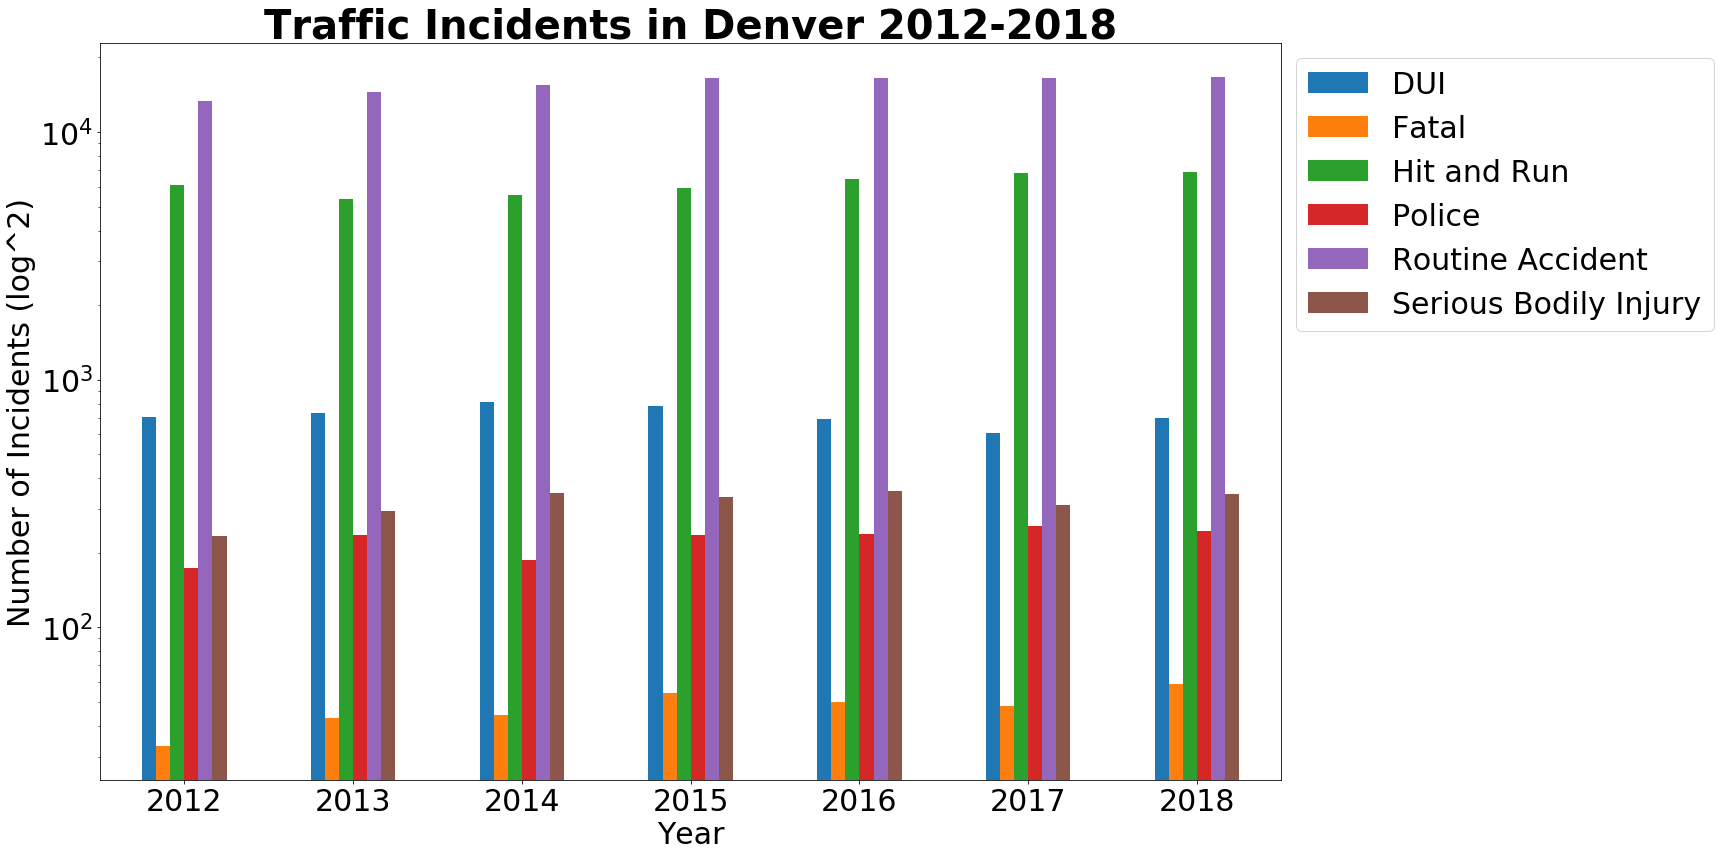

In [12]:
# Create bar graph
unstacked_traffic_data_for_bars.plot(kind='bar', figsize = (24,12))
plt.title('Traffic Incidents in Denver 2012-2018', fontsize = 40, fontweight = 'bold')
plt.xticks(rotation='horizontal', fontsize = 30)
plt.yticks(fontsize = 30)
plt.yscale('log')
plt.ylabel('Number of Incidents (log^2)', fontsize = 30)
plt.xlabel('Year', fontsize = 30)
plt.legend(loc='upper left', fontsize=30,  bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('../Output/clustered_traffic_bar_chart.png')
plt.show()

In [13]:
# Display above "bar graph" dataframe, this time with a final "Total" column
unstacked_traffic_data_for_bars['Total'] = unstacked_traffic_data_for_bars.sum(axis = 1)
unstacked_traffic_data_for_bars

OFFENSE_DESCRIPTION,DUI,Fatal,Hit and Run,Police,Routine Accident,Serious Bodily Injury,Total
YEAR,,,,,,,
2012,707,33,6129,173,13284,234,20560
2013,731,43,5359,236,14518,295,21182
2014,815,44,5577,186,15474,348,22444
2015,779,54,5933,236,16506,334,23842
2016,692,50,6444,238,16476,354,24254
2017,608,48,6809,257,16583,312,24617
2018,698,59,6861,244,16697,346,24905


The following sub-section continues the categorical breakdown of accidents, this time by plotting pie charts.  The population dataset is used for the first time to supplement our pie charts with these additional details.

In [14]:
#read in second dataset to obtain population data
pop_data = pd.read_csv('../Resources/Population_Projections_in_Denver_County.csv')
pop_data

,year,totalPopulation
0,2012,634471
1,2013,648162
2,2014,662855
3,2015,680658
4,2016,693292
5,2017,703462
6,2018,713529


In [15]:
# Pivot the above traffic incident dataframe
unstacked_traffic_data_for_pies = traffic_data_groupby_yearandoffense.count()['OVERALL_OFFENSE_CODE'].unstack(level = 0)
unstacked_traffic_data_for_pies['Total'] = unstacked_traffic_data_for_pies.sum(axis = 1)
unstacked_traffic_data_for_pies

YEAR,2012,2013,2014,2015,2016,2017,2018,Total
OFFENSE_DESCRIPTION,,,,,,,,
DUI,707,731,815,779,692,608,698,5030
Fatal,33,43,44,54,50,48,59,331
Hit and Run,6129,5359,5577,5933,6444,6809,6861,43112
Police,173,236,186,236,238,257,244,1570
Routine Accident,13284,14518,15474,16506,16476,16583,16697,109538
Serious Bodily Injury,234,295,348,334,354,312,346,2223


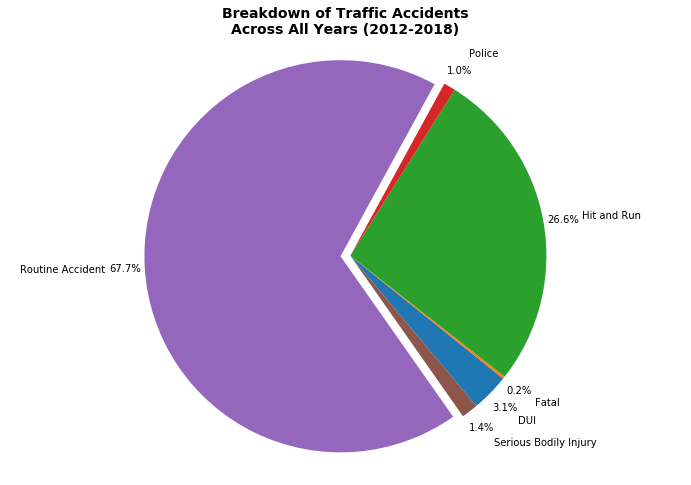

In [16]:
# Plot pie chart over the above "Total" column
explode = (0, 0, 0, 0, 0.05, 0)

plt.figure(figsize = (12, 8))
plt.pie(x = unstacked_traffic_data_for_pies['Total'], labels = unstacked_traffic_data_for_pies.index, autopct = '%1.1f%%',
        startangle = 310, explode = explode, pctdistance = 1.1, labeldistance = 1.2)
plt.title("""Breakdown of Traffic Accidents
Across All Years (2012-2018)""", fontweight = 'bold', fontsize = 14)
plt.axis('equal')
plt.savefig('../Output/Pie_Chart_All_Years.png')
plt.show()

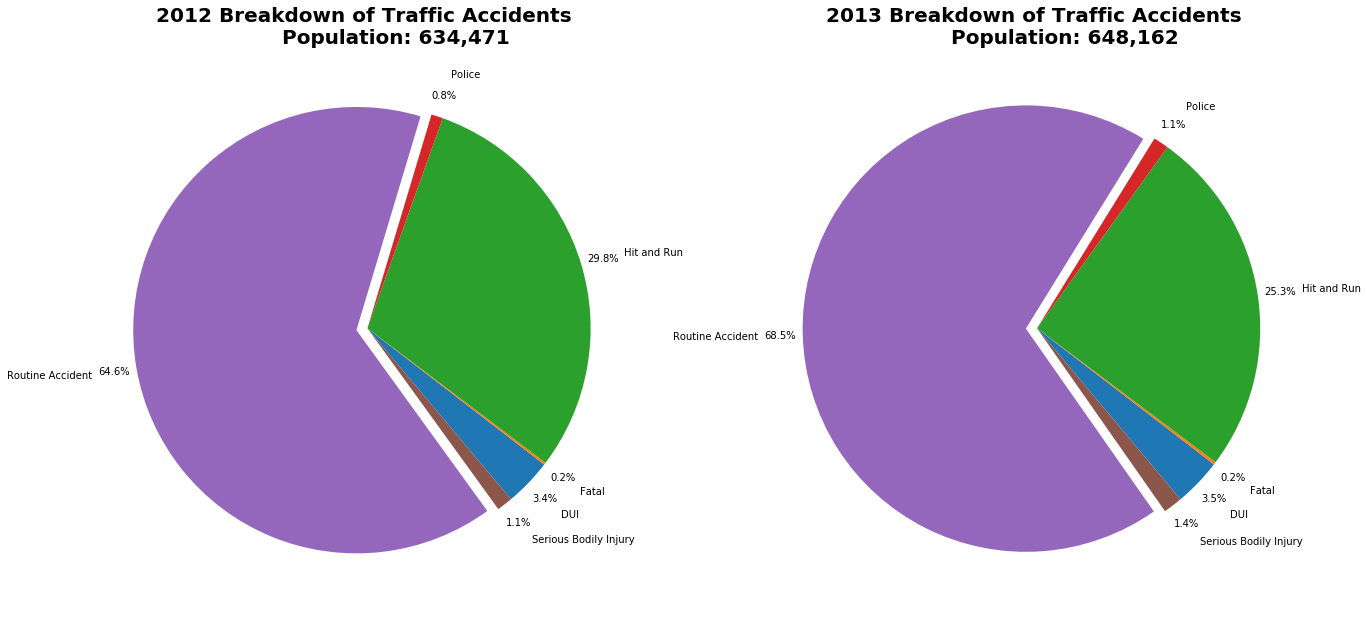

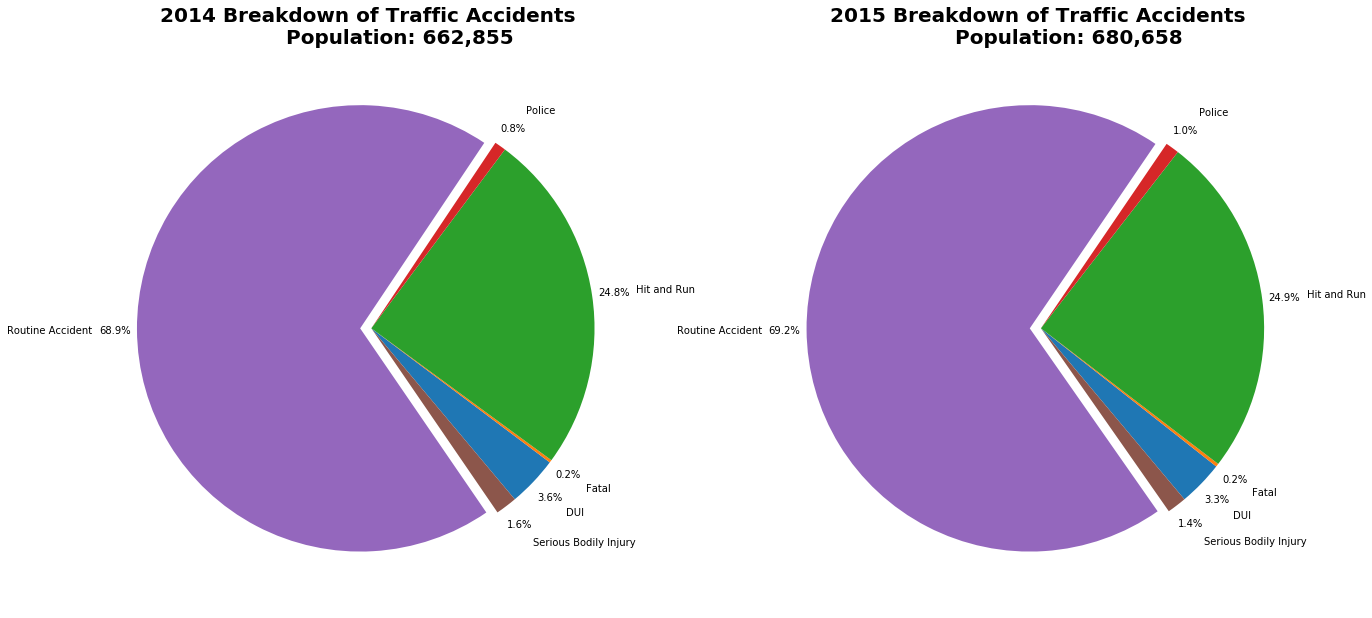

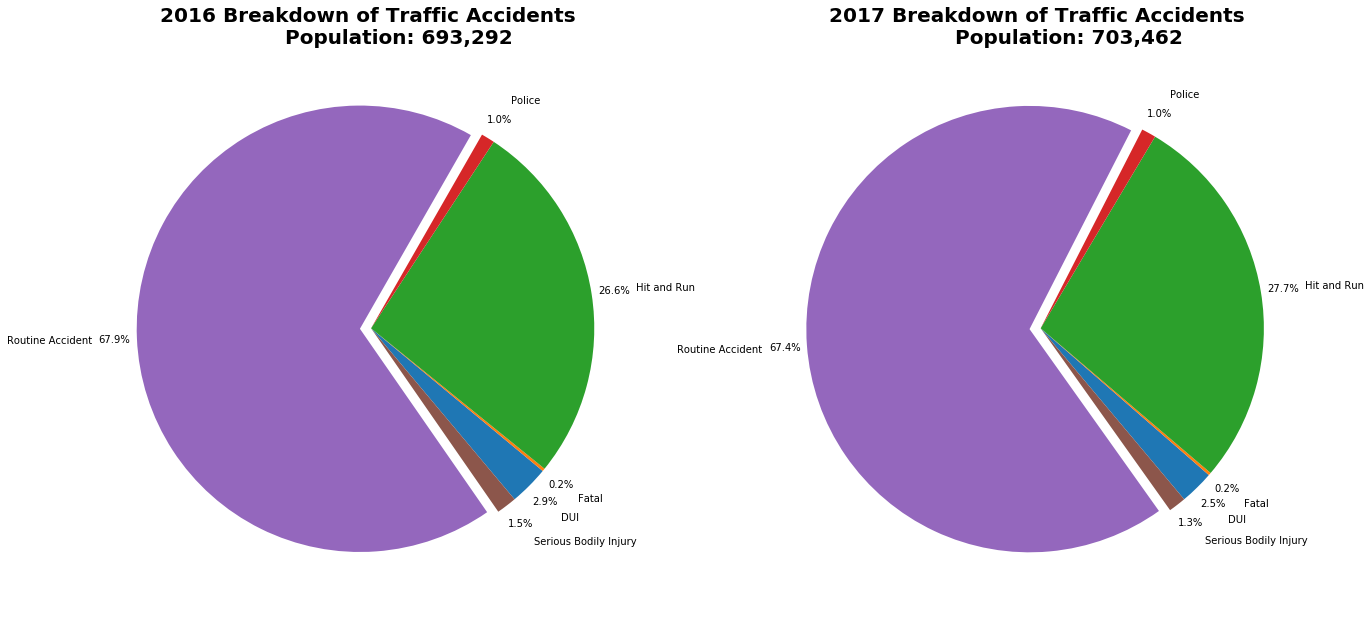

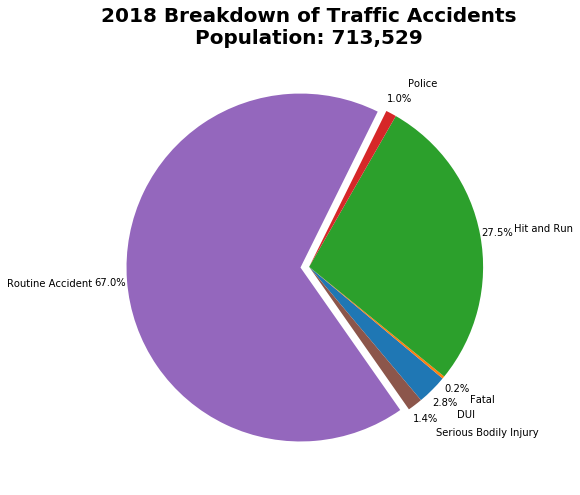

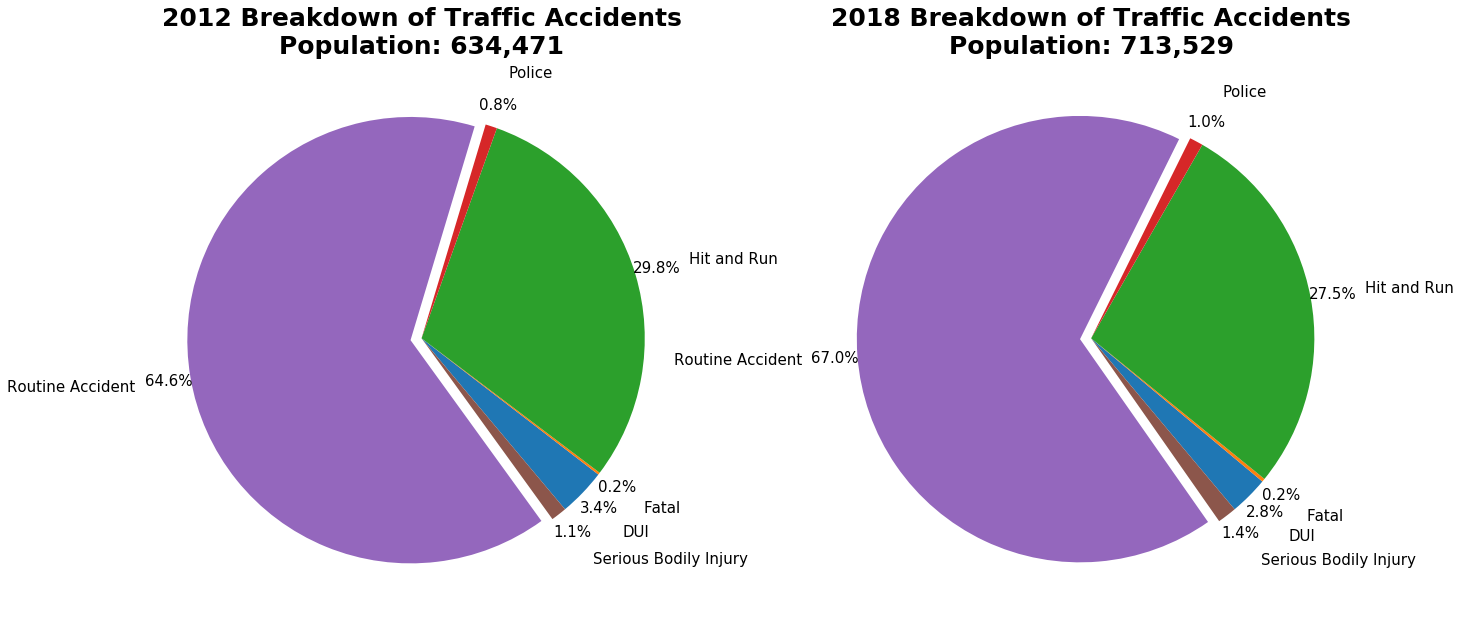

In [17]:
# Plot pie charts that illustrate breakdown of percentages of accidents (one chart per year)
# Include population totals in the chart titles

# The following for loop plots the first six years' worth of data in three figures (2 years per figure)
for i in range(3):
    plt.figure(figsize = (22, 12))

    # Iterate through each column of the "unstack" dataframe above and make a pie chart for each column (year)
    for j in range(i * 2, i * 2 + 2):
        plt.subplot(1, 2, 1 if j % 2 == 0 else 2)
        plt.pie(x = unstacked_traffic_data_for_pies[unstacked_traffic_data_for_pies.columns[j]],
                labels = unstacked_traffic_data_for_pies.index, autopct = '%1.1f%%',
                startangle = 310, explode = explode, pctdistance = 1.1, labeldistance = 1.2)
        totalPop = '{:,}'.format(pop_data.loc[j, 'totalPopulation'])
        plt.title(f"""{unstacked_traffic_data_for_pies.columns[j]} Breakdown of Traffic Accidents 
        Population: {totalPop}""", fontweight = 'bold', fontsize = 20)
    plt.savefig(f'../Output/Pie_Chart_{i}.png')

# Plot final year (2018), since not captured in for loop
plt.figure(figsize = (12, 8))
plt.pie(x = unstacked_traffic_data_for_pies['2018'], labels = unstacked_traffic_data_for_pies.index,
        autopct = '%1.1f%%', startangle = 310, explode = explode, pctdistance = 1.1, labeldistance = 1.2)
totalPop = '{:,}'.format(pop_data.loc[6, 'totalPopulation'])
plt.title(f"""2018 Breakdown of Traffic Accidents
Population: {totalPop}""", fontweight = 'bold', fontsize = 20)

plt.savefig('../Output/Pie_Chart_3.png')

# Plot 2012 and 2018 side by side
plt.figure(figsize = (22,12))
plt.subplot(1, 2, 1)
plt.pie(x = unstacked_traffic_data_for_pies['2012'], labels = unstacked_traffic_data_for_pies.index,
                                    autopct = '%1.1f%%', startangle = 310, explode = explode, pctdistance = 1.1, 
                                    labeldistance = 1.25, textprops = {'fontsize': 15})
totalPop = '{:,}'.format(pop_data.loc[0, 'totalPopulation'])
plt.title(f"""2012 Breakdown of Traffic Accidents
Population: {totalPop}""", fontweight = 'bold', fontsize = 25)

plt.subplot(1, 2, 2)
plt.pie(x = unstacked_traffic_data_for_pies['2018'], labels = unstacked_traffic_data_for_pies.index, autopct = '%1.1f%%',
        startangle = 310, explode = explode, pctdistance = 1.1, labeldistance = 1.25, textprops = {'fontsize': 15})
totalPop = '{:,}'.format(pop_data.loc[6, 'totalPopulation'])
plt.title(f"""2018 Breakdown of Traffic Accidents
Population: {totalPop}""", fontweight = 'bold', fontsize = 25)

plt.savefig('../Output/Pie_Chart_4.png')

plt.show()

---

### Question 2:  In what locations are traffic incidents most highly concentrated?  Do the presence of traffic cameras correlate with reduced numbers of incidents?

In this section we make use of heat maps (through the use of gmaps) to illustrate the concentration of traffic incidents and traffic cameras.  Our heat maps illustrate that the most highly concentrated incidents are along I-25, I-70, and in the heart of downtown Denver.  We also observe that an increased concentration of traffic cameras does correlate with a reduced number of incidents, though this is not enough prove causation.

#### Traffic Incident Heatmaps

In [20]:
# # code to generate yearly figures
# #print(gkey)
# gmaps.configure(api_key=gkey)

# #no way to export map or save map as an image as a command have to generate the map for each year individually.
# fig_layout = {'width':'500px','height':'500px','border':'1px solid black'}

#change year number for each map
# locations = traffic_data[traffic_data['YEAR'] == "2018"][['LAT','LON']]
# fig = gmaps.figure(center=(39.72,-104.95), zoom_level=11,layout=fig_layout)
# fig.add_layer(gmaps.heatmap_layer(locations,point_radius=5,max_intensity=30))
# fig

## Traffic Accident Heatmap by Year
!["Traffic Accidents by Year"](../Output/accidents_by_year.gif "Accidents by Year")

In [21]:
# # following two cells code to manually generate each hour

# #init the count for the next cell for looping (see next cell)
# i = 0

In [22]:
# if i<9:
#     traffic_data_by_hour = traffic_data[(traffic_data['TIME'] >= '0' + str(i) + ':00:00') &
#                                         (traffic_data['TIME'] < '0' + str(i+1) + ':00:00')]
# elif i==9: #my script breaks between 0x and xx so had to write an exception for 09 to 10.
#     traffic_data_by_hour = traffic_data[(traffic_data['TIME'] >= '0' + str(i) + ':00:00') &
#                                         (traffic_data['TIME'] < str(i+1) + ':00:00')]        
# elif i>=10:
#     traffic_data_by_hour = traffic_data[(traffic_data['TIME'] >= str(i) + ':00:00') &
#                                         (traffic_data['TIME'] < str(i+1) + ':00:00')]

# #print(i) #printing i just to check the right hour is printing
# locations = traffic_data_by_hour[['LAT','LON']]
# fig = gmaps.figure(center=(39.72,-104.95), zoom_level=11,layout=fig_layout)
# fig.add_layer(gmaps.heatmap_layer(locations,point_radius=5,max_intensity=15))

# i += 1

# fig

## Traffic Accident Heatmap by Hour
!["Traffic Accidents by Hour"](../Output/accidents_by_hour_slow.gif "Accidents by Hour")

#### Traffic Camera Heatmap

In [10]:
# Read in traffic camera dataset
traffic_cam_data = pd.read_csv('../Resources/intelligent_traffic_system_devices.csv')
traffic_cam_data.head()

,ITS_DEVICE_ID,ITS_DEVICE_TYPE,RECORD_DATE,LOCATION_DESC,ITS_DEVICE_OWNER
0,626,TRAFFICCAM,2/25/2016 0:00,Brighton and 31st,PWTES
1,627,TRAFFICCAM,2/28/2016 0:00,Brighton and 44th,PWTES
2,628,TRAFFICCAM,3/13/2016 0:00,Colfax and Wolff,PWTES
3,146,Traffic camera,1/9/2012 0:00,15th and Welton,CCD Traffic Engineering
4,147,Traffic camera,1/9/2012 0:00,15th and Larimer,CCD Traffic Engineering


In [11]:
# Clean up column with date information
traffic_cam_data_date = pd.to_datetime(traffic_cam_data['RECORD_DATE'])
traffic_cam_data['DATE'] = traffic_cam_data_date

traffic_cam_data_clean_date = traffic_cam_data.drop(columns=['RECORD_DATE'])
traffic_cam_data_clean_date.head()

,ITS_DEVICE_ID,ITS_DEVICE_TYPE,LOCATION_DESC,ITS_DEVICE_OWNER,DATE
0,626,TRAFFICCAM,Brighton and 31st,PWTES,2016-02-25
1,627,TRAFFICCAM,Brighton and 44th,PWTES,2016-02-28
2,628,TRAFFICCAM,Colfax and Wolff,PWTES,2016-03-13
3,146,Traffic camera,15th and Welton,CCD Traffic Engineering,2012-01-09
4,147,Traffic camera,15th and Larimer,CCD Traffic Engineering,2012-01-09


In [25]:
# # THE FOLLOWING CODE HAS BEEN OUTPUT TO '../Resources/traffic_cam_lat_and_lng.csv' SO THAT WE DON'T RUN IT AGAIN
# # LEAVE THIS CODE COMMENTED OUT

# # Make API requests using above dataframe's location data.
# # Add latitude/longitude for each response to the corresponding list
# lat = []
# lng = []
# for row in traffic_cam_data_clean_date['LOCATION_DESC']:
#     target_location = row + ', Denver, CO'
#     target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
#     'address={0}&key={1}').format(target_location, gkey)
#     geo_data = requests.get(target_url).json()
#     print(row)
#     if geo_data["status"] == "OK":
#         lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
#         lng.append(geo_data["results"][0]["geometry"]["location"]["lng"])
#     else:
#         lat.append("")
#         lng.append("")

# # Use new lat/lng lists to create new lat/lng columns in the traffic cam dataframe
# traffic_cam_data_clean_date['Lat'] = lat
# traffic_cam_data_clean_date['Lng'] = lng
# traffic_cam_data_clean_date.head()

In [12]:
# Export dataframe to .csv (see comments above regarding avoiding re-doing the API requests)
# traffic_cam_data_clean_date.to_csv('../Resources/traffic_cam_lat_and_lng.csv')

final_traffic_cam_data = pd.read_csv('../Resources/traffic_cam_lat_and_lng.csv').drop(columns='Unnamed: 0')
final_traffic_cam_data.head()

,ITS_DEVICE_ID,ITS_DEVICE_TYPE,LOCATION_DESC,ITS_DEVICE_OWNER,DATE,Lat,Lng
0,626,TRAFFICCAM,Brighton and 31st,PWTES,2016-02-25,39.766576,-104.983672
1,627,TRAFFICCAM,Brighton and 44th,PWTES,2016-02-28,39.778448,-104.968431
2,628,TRAFFICCAM,Colfax and Wolff,PWTES,2016-03-13,39.740340,-105.048678
3,146,Traffic camera,15th and Welton,CCD Traffic Engineering,2012-01-09,39.743602,-104.992526
4,147,Traffic camera,15th and Larimer,CCD Traffic Engineering,2012-01-09,39.748277,-104.998625


In [13]:
# Generate traffic camera heat maps
gmaps.configure(api_key=gkey)
final_traffic_cam_data['Lat'].replace('', np.nan,inplace=True)
final_traffic_cam_data.dropna(axis=0,how='any',inplace=True)
cam_fig_layout = {'width':'500px','height':'500px','border':'1px solid black'}
cam_locations = final_traffic_cam_data[['Lat','Lng']]
cam_fig = gmaps.figure(center=(39.73,-104.96), zoom_level=12,layout=cam_fig_layout)
cam_fig.add_layer(gmaps.heatmap_layer(cam_locations,point_radius=6, max_intensity=1, opacity = 0.5))
cam_fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', width='500px'))

In [14]:
#re-generate 2018 accidents heat map
gmaps.configure(api_key=gkey)

fig_layout = {'width':'500px','height':'500px','border':'1px solid black'}

# change year number for each map
locations = traffic_data[traffic_data['YEAR'] == "2018"][['LAT','LON']]
fig = gmaps.figure(center=(39.73,-104.96), zoom_level=12,layout=fig_layout)
fig.add_layer(gmaps.heatmap_layer(locations,point_radius=7,max_intensity=38, opacity=0.5))
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', width='500px'))

## Traffic Camera heatmap vs Traffic Accident heatmap
!["Traffic cam heatmap compared to traffic accident heatmap"](../Output/traffic_cam_vs_accident_heatmap.png)

---

### Question 3:  Has the occurrence of traffic incidents worsened as population has grown?

In this section we make use of line graphs to plot both population growth and the increase of traffic incidents over time.  As expected, both sets of numbers have increased over the years.  
  
  The final line graph, however, combines both the population data and the traffic incident data to calculate total number traffic incidents per 1000 people.  This line graph illustrates that the occurrence of traffic incidents (again, per 1000 people) has actually improved since 2015.  
  
  One possible reason for this could be an improvement in public transportation, but this would require further research.

In [86]:
# Use original traff_data dataframe to create a new groupby object, aggregating by count
traffic_data_total_incidents_by_year = traffic_data.groupby(by="YEAR").count().reset_index()
traffic_data_total_incidents_by_year

,YEAR,OVERALL_OFFENSE_CODE,OFFENSE_DESCRIPTION,MONTH,DAY,TIME,LAT,LON,INCIDENT_ADDRESS,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND
0,2012,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560,20560
1,2013,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182,21182
2,2014,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444,22444
3,2015,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842,23842
4,2016,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254,24254
5,2017,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617,24617
6,2018,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905,24905


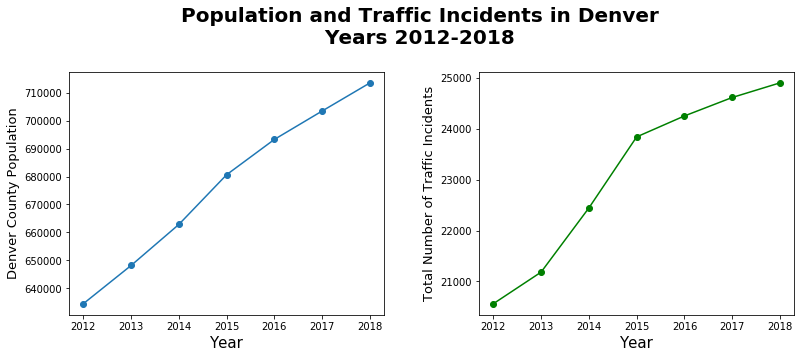

In [87]:
# Plot population growth and traffic incidents over time
fig, axs = plt.subplots(1, 2, figsize=(13,5))

axs[0].plot(pop_data.year, pop_data.totalPopulation, marker='o')
axs[0].set_ylabel('Denver County Population', fontsize=13)
axs[0].set_xlabel('Year', fontsize=15)
axs[1].plot(pop_data.year, traffic_data_total_incidents_by_year.OVERALL_OFFENSE_CODE, marker='o', color='green')
axs[1].set_ylabel('Total Number of Traffic Incidents', fontsize=13)
axs[1].set_xlabel('Year', fontsize=15)

plt.subplots_adjust(wspace = 0.3, top = 0.8)

fig.suptitle('''Population and Traffic Incidents in Denver
Years 2012-2018''', fontsize = 20, fontweight = 'bold')

plt.savefig('../Output/Line_Graph_0.png')
plt.show()

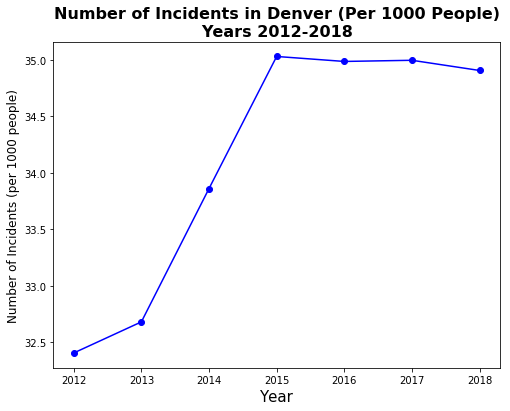

In [88]:
# Final plot: takes (total incidents / population) * 1000
plt.figure(figsize = (8,6))
plt.plot(pop_data.year, traffic_data_total_incidents_by_year.OVERALL_OFFENSE_CODE / pop_data.totalPopulation * 1000, \
         marker='o', color='blue')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Incidents (per 1000 people)', fontsize=12)
plt.title('''Number of Incidents in Denver (Per 1000 People)
Years 2012-2018''', fontsize = 16, fontweight = 'bold')

plt.savefig('../Output/Line_Graph_1.png')
plt.show()